In [1]:
# Copyright (c) Microsoft Corporation.
# Licensed under the MIT License.
import sys
sys.path.append("D:/codeRepository/BatteryML/")
from scripts.pipeline import Pipeline
from src.visualization.plot_helper import plot_capacity_degradation, plot_cycle_attribute, plot_result
from scripts.download import download_raw_data
from scripts.preprocess import convert_data_format

%load_ext autoreload
%autoreload 2

# Prepare data

In this example, we use the MATR dataset [1] to demonstrate the usage of our baseline model.    
[1] Severson et al. "Data-driven prediction of battery cycle life before capacity degradation." Nature Energy volume 4, pages 383–391 (2019).  


In [2]:
"""
Download battery public datasets.

- dataset_name (str, optional): Name of the specific dataset to download.
  - If set, only the specified dataset will be downloaded.
  - If not set (None), all available preset datasets will be downloaded, including HUST, MATR, CALCE and RWTH.


Note: Due to batteryarchive.com stopping their download service, OX, SNL, HNEI, and UL_PUR datasets are not available for download. Please contact the respective organizations to request access. 
You can refer to the BatteryML/dataprepare.md document for more detailed information.
"""
download_raw_data(dataset_name='matr')

[INFO] Downloads saving to /home/BatteryML/data/raw/MATR/2017-05-12_batchdata_updated_struct_errorcorrect.mat.


  0%|                    | 3.91MB/2.82GB:  [00:00<01:01, 45.61MB/s]

100%|████████████████████| 2.82GB/2.82GB:  [00:57<00:00, 53.44MB/s]   


[INFO] Downloads saving to /home/BatteryML/data/raw/MATR/2017-06-30_batchdata_updated_struct_errorcorrect.mat.


100%|████████████████████| 1.87GB/1.87GB:  [00:37<00:00, 55.18MB/s]   


[INFO] Downloads saving to /home/BatteryML/data/raw/MATR/2018-04-12_batchdata_updated_struct_errorcorrect.mat.


100%|████████████████████| 3.01GB/3.01GB:  [01:05<00:00, 54.51MB/s]   


[INFO] Downloads saving to /home/BatteryML/data/raw/MATR/2019-01-24_batchdata_updated_struct_errorcorrect.mat.


100%|████████████████████| 2.42GB/2.42GB:  [00:51<00:00, 36.41MB/s]   


[INFO] ['MATR'] datasets downloaded.


In [5]:
"""
Convert data format to BatteryML's unified data format.

- dataset_name (str, optional): Name of the specific dataset to convert.
  - If set, only the specified dataset will be converted.
  - If not set (None), all datasets in the BatteryML/data/raw folder will be processed.

Currently supported datasets for preprocessing: SNL, OX, UL_PUR, HNEI, MATR, HUST, RWTH, and CALCE. More data formats will be added in the future.  
"""

convert_data_format(dataset_name='matr')

Processing dataset MATR:   0%|          | 0/1 [00:00<?, ?it/s]

Processing dataset MATR: 100%|██████████| 1/1 [19:17<00:00, 1157.05s/it]


# Basic Usage Of BatteryML Pipeline

## Create pipeline

In [2]:
# Create a pipeline with a configuration file, specifying the device and workspace. 
# Developers need to modify the data, feature, model and other related settings in the config file in advance. 
pipeline = Pipeline(config_path='configs/baselines/sklearn/rf/snl.yaml')

Seed is set to 0.


Info: Setting workspace to d:\codeRepository\BatteryML\workspaces\snl. If you do not want any information to be stored, explicitly call with flag `--workspace none`.
Extracting features: 100%|██████████| 9/9 [00:00<00:00, 285.13it/s]


## Plot train and test data

In [3]:
# get raw data from pipeline
train_cells, test_cells  = pipeline.train_cells, pipeline.test_cells

In [13]:
train_cells

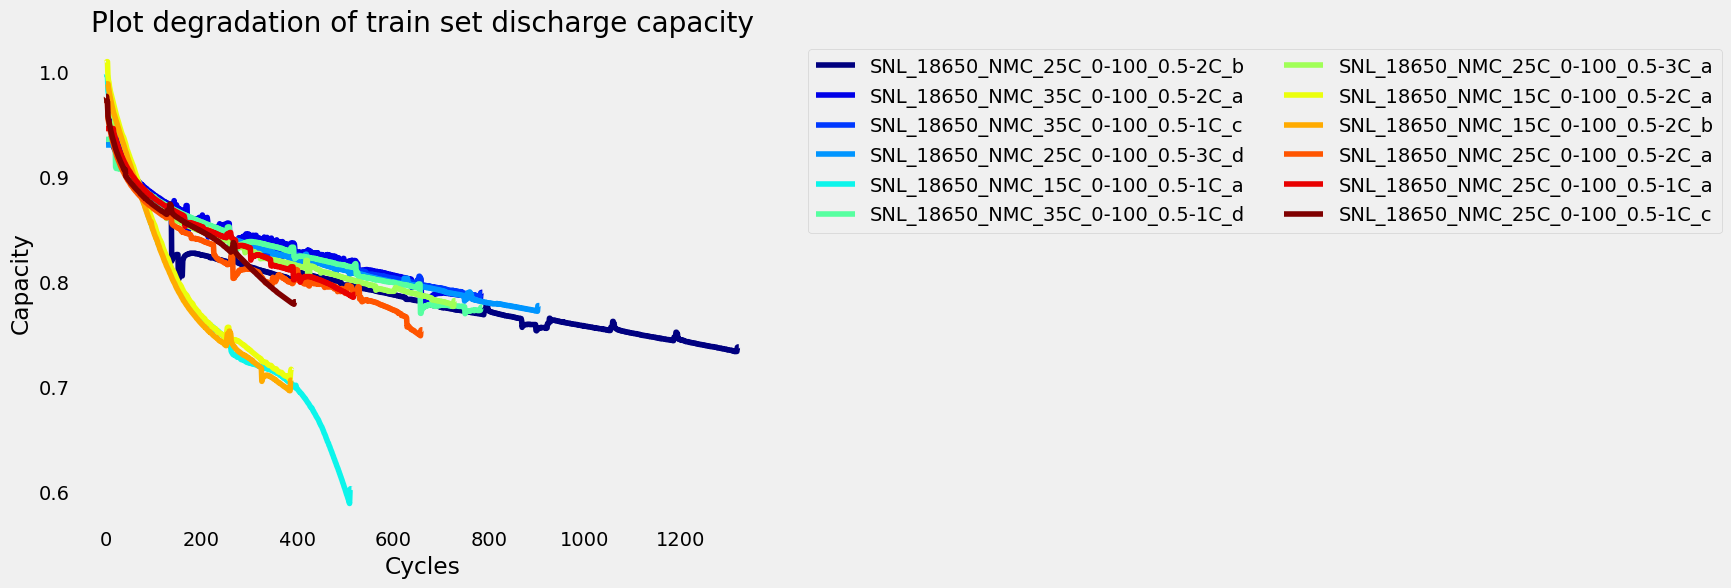

In [6]:
# display (train set) all battery cells' capacity degradation curve using plot_capacity_degradation function
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
plot_capacity_degradation(train_cells, title='Plot degradation of train set discharge capacity', figsize=(8,6), n_legend_cols=2)

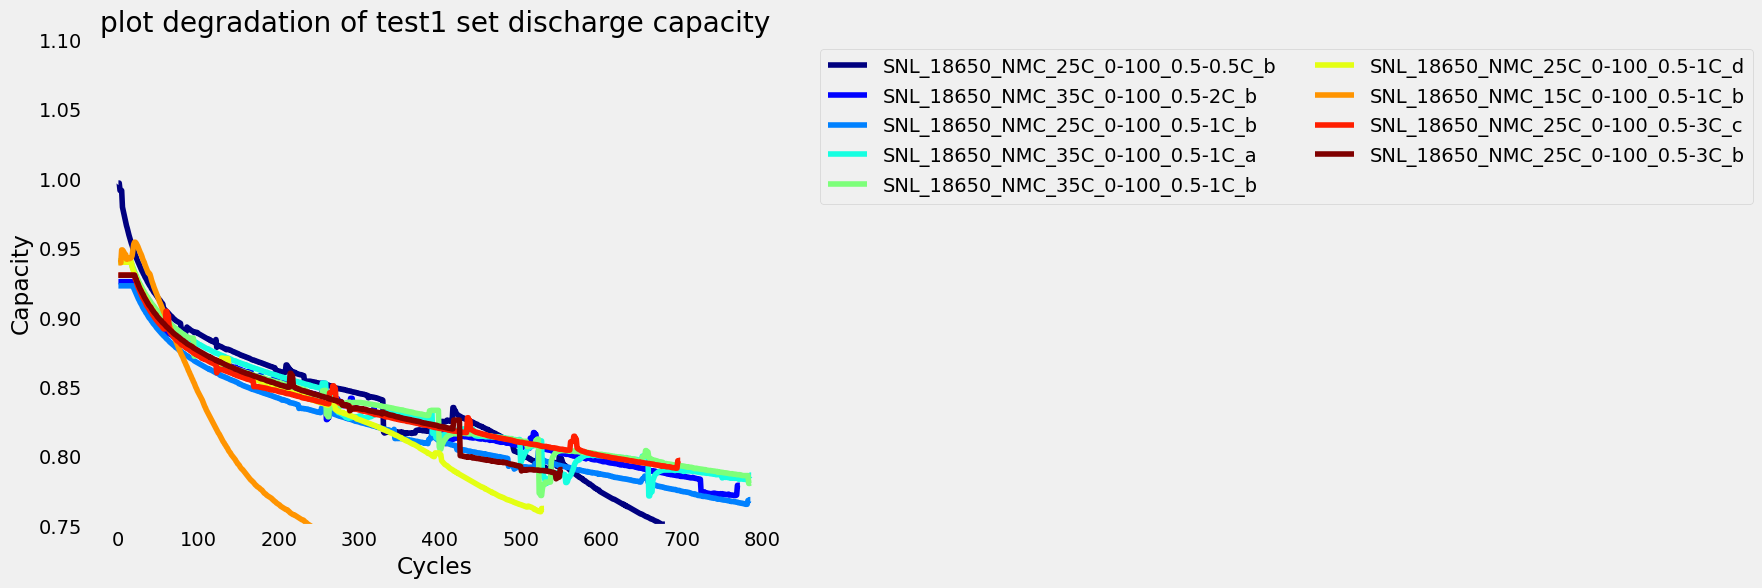

In [7]:
# display (test set) all battery cells' capacity degradation curve using plot_capacity_degradation function

plot_capacity_degradation(test_cells, title='plot degradation of test1 set discharge capacity', figsize=(8,6), n_legend_cols=2, ylim=(0.75,1.1))

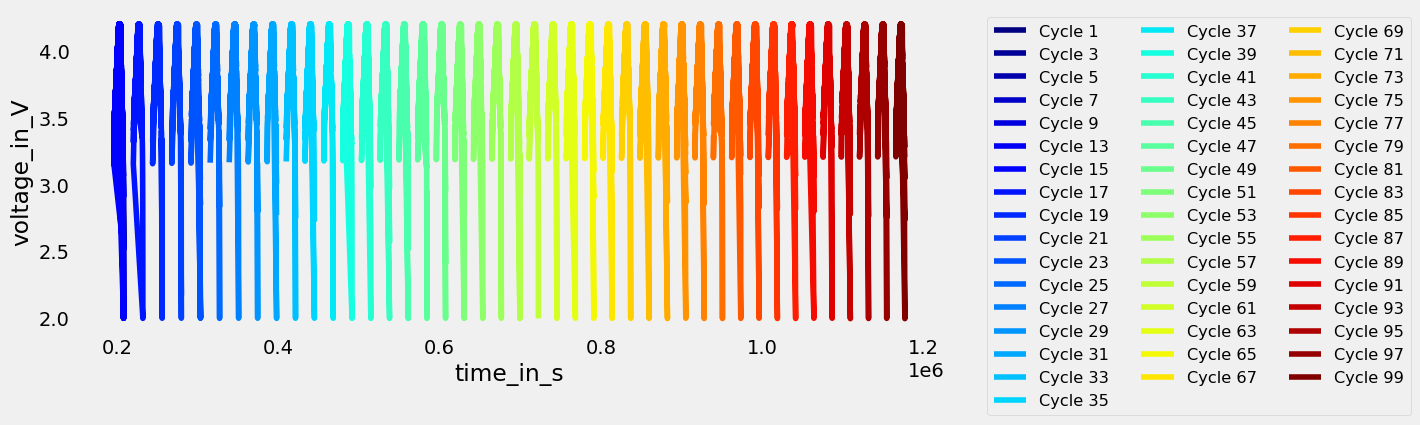

In [8]:
# plot cycle raw attribute such as "voltage_in_V","current_in_A","charge_capacity_in_Ah","discharge_capacity_in_Ah"...

cell_0 = train_cells[10]
indices = [i for i in range(0, 100, 2) if i!=10 ]
plot_cycle_attribute(cell_0.cycle_data, 'voltage_in_V', cycle_indices=indices, figsize=(10, 4))

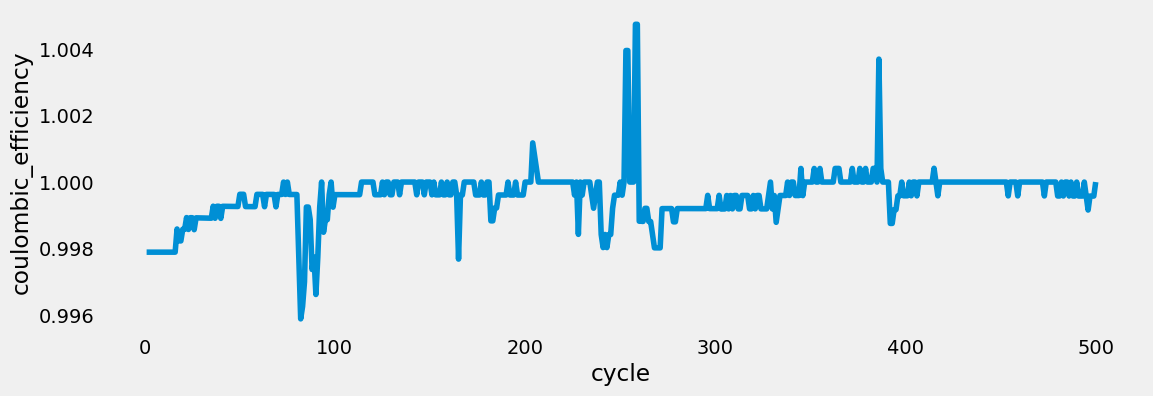

In [9]:
# plot cycle attribute such as "coulombic_efficiency"...
indices = [i for i in range(500) if i!=10 ]
plot_cycle_attribute(cell_0.cycle_data, 'coulombic_efficiency', cycle_indices=indices)

## Train and evaluate model

In [10]:
# train model, and the model will be trained according to the configuration you previously filled out in the config file
train_loss , test_loss = pipeline.train()

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

In [10]:
# Also you can use a previously trained model to do evaluation on this data
test_loss = pipeline.evaluate(checkpoint='<your checkpoint path>')

## Plot result

No handles with labels found to put in legend.


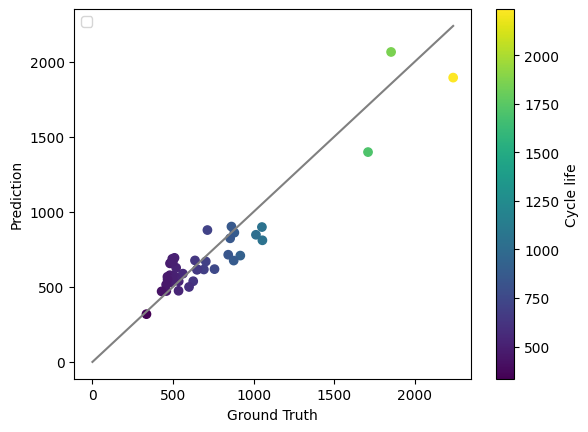

In [10]:
ground_truth = pipeline.target.to('cpu')
prediction = pipeline.prediction.to('cpu')
plot_result(ground_truth, prediction)

# Baseline

In [11]:
import os
import pandas as pd
config_dir = 'configs/baselines/'
data1 = 'matr_1'
data2 = 'matr_2'
result=[]
for method_type in os.listdir(config_dir):
    for method in os.listdir(os.path.join(config_dir, method_type)):
        print(method)
        config_path = os.path.join(config_dir, method_type, method, f'{data1}.yaml')
        pipeline = Pipeline(config_path=config_path,
                    device='cuda', 
                    workspace=f'workspaces/{method}')
        train_loss , test_loss = pipeline.train()
        
        config_path = os.path.join(config_dir, method_type, method, f'{data2}.yaml')
        pipeline = Pipeline(config_path=config_path,
                    device='cuda', 
                    workspace=f'workspaces/{method}')
        test2_loss = pipeline.evaluate(checkpoint=f'workspaces/{method}/latest.ckpt')
      
        result.append([method, train_loss, test_loss, test2_loss])

res = pd.DataFrame(data=result, columns=['method', 'train_RMSE', 'test_RMSE', 'test2_RMSE'])

discharge_model
Seed is set to 0.


Extracting features: 100%|██████████| 42/42 [00:01<00:00, 35.99it/s]


train_RMSE:79.23 test_RMSE:329.05
Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:01<00:00, 40.00it/s]


test_RMSE: 148.58
rf
Seed is set to 0.


Extracting features: 100%|██████████| 42/42 [00:00<00:00, 715.81it/s]


train_RMSE:101.39 test_RMSE:164.31
Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:00<00:00, 811.65it/s]


test_RMSE: 231.41
gpr
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_6fed4389f6006c2f10229b6327fc01ac.pkl.


train_RMSE:0.00 test_RMSE:153.93
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_e27a6fd52a3a4d66455b9eb27c3be8bc.pkl.


test_RMSE: 223.80
plsr
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_6fed4389f6006c2f10229b6327fc01ac.pkl.


train_RMSE:53.14 test_RMSE:103.65
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_e27a6fd52a3a4d66455b9eb27c3be8bc.pkl.


test_RMSE: 180.53
ridge
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_6fed4389f6006c2f10229b6327fc01ac.pkl.


train_RMSE:45.89 test_RMSE:115.79
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_e27a6fd52a3a4d66455b9eb27c3be8bc.pkl.


test_RMSE: 183.80
full_model
Seed is set to 0.


Extracting features: 100%|██████████| 42/42 [00:04<00:00,  8.42it/s]


train_RMSE:69.60 test_RMSE:166.80
Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:03<00:00, 10.03it/s]


test_RMSE: 1074.40
variance_model
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_c13c3e3fff45570ba9f07b199bd7fb9f.pkl.


train_RMSE:122.05 test_RMSE:136.13
Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:00<00:00, 1354.83it/s]


test_RMSE: 211.24
pcr
Seed is set to 0.


Extracting features: 100%|██████████| 42/42 [00:00<00:00, 789.90it/s]


train_RMSE:77.82 test_RMSE:90.44
Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:00<00:00, 828.14it/s]


test_RMSE: 186.54
dummy
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_c13c3e3fff45570ba9f07b199bd7fb9f.pkl.


train_RMSE:327.21 test_RMSE:398.82
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_88b6851c7a1d3d245e240171d6bf1803.pkl.


test_RMSE: 510.63
cnn
Seed is set to 0.


Traning:  10%|▉         | 98/1000 [00:05<00:38, 23.26it/s]

[100/1000] RMSE 164.47


Traning:  20%|█▉        | 197/1000 [00:09<00:34, 23.35it/s]

[200/1000] RMSE 81.16


Traning:  30%|██▉       | 297/1000 [00:13<00:30, 23.39it/s]

[300/1000] RMSE 68.61


Traning:  40%|███▉      | 397/1000 [00:18<00:26, 23.09it/s]

[400/1000] RMSE 70.01


Traning:  50%|████▉     | 497/1000 [00:22<00:21, 23.32it/s]

[500/1000] RMSE 65.80


Traning:  60%|█████▉    | 597/1000 [00:26<00:17, 23.29it/s]

[600/1000] RMSE 66.09


Traning:  70%|██████▉   | 697/1000 [00:31<00:13, 23.12it/s]

[700/1000] RMSE 68.77


Traning:  80%|███████▉  | 797/1000 [00:35<00:08, 23.10it/s]

[800/1000] RMSE 70.46


Traning:  90%|████████▉ | 897/1000 [00:39<00:04, 23.49it/s]

[900/1000] RMSE 72.84


Traning: 100%|█████████▉| 997/1000 [00:44<00:00, 23.02it/s]

[1000/1000] RMSE 76.54


Traning: 100%|██████████| 1000/1000 [00:44<00:00, 22.58it/s]

train_RMSE:33.62 test_RMSE:76.54


Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:03<00:00, 11.37it/s]


test_RMSE: 215.42
lstm
Seed is set to 0.


Info: Load datasets from cache cache/battery_cache_912b49089b9c171cd39fe4d0cdb8bbc9.pkl.
Traning:  10%|▉         | 96/1000 [00:00<00:04, 216.53it/s]

[100/1000] RMSE 103.64


Traning:  19%|█▊        | 187/1000 [00:00<00:03, 270.18it/s]

[200/1000] RMSE 116.61


Traning:  28%|██▊       | 281/1000 [00:01<00:02, 294.32it/s]

[300/1000] RMSE 101.11


Traning:  38%|███▊      | 376/1000 [00:01<00:02, 305.21it/s]

[400/1000] RMSE 103.89


Traning:  47%|████▋     | 470/1000 [00:01<00:01, 305.23it/s]

[500/1000] RMSE 108.48


Traning:  60%|█████▉    | 597/1000 [00:02<00:01, 309.12it/s]

[600/1000] RMSE 114.04


Traning:  69%|██████▉   | 693/1000 [00:02<00:00, 310.16it/s]

[700/1000] RMSE 116.93


Traning:  79%|███████▉  | 789/1000 [00:02<00:00, 313.07it/s]

[800/1000] RMSE 123.12


Traning:  88%|████████▊ | 885/1000 [00:03<00:00, 309.17it/s]

[900/1000] RMSE 113.47


Traning:  98%|█████████▊| 980/1000 [00:03<00:00, 309.83it/s]

[1000/1000] RMSE 122.28


Traning: 100%|██████████| 1000/1000 [00:03<00:00, 280.23it/s]

train_RMSE:31.26 test_RMSE:122.28



Info: Load datasets from cache cache/battery_cache_1dd74c331b10b62948e686bc8e80ab32.pkl.


Seed is set to 0.
test_RMSE: 202.35
mlp
Seed is set to 0.


Traning:   2%|▏         | 92/5000 [00:00<00:16, 306.25it/s]

[100/5000] RMSE 398.62


Traning:   4%|▎         | 187/5000 [00:00<00:15, 307.65it/s]

[200/5000] RMSE 386.96


Traning:   6%|▌         | 281/5000 [00:00<00:15, 307.57it/s]

[300/5000] RMSE 304.70


Traning:   8%|▊         | 375/5000 [00:01<00:15, 306.84it/s]

[400/5000] RMSE 291.18


Traning:  10%|▉         | 499/5000 [00:01<00:14, 300.70it/s]

[500/5000] RMSE 280.16


Traning:  12%|█▏        | 594/5000 [00:01<00:14, 307.55it/s]

[600/5000] RMSE 271.18


Traning:  14%|█▍        | 689/5000 [00:02<00:13, 308.84it/s]

[700/5000] RMSE 258.92


Traning:  16%|█▌        | 783/5000 [00:02<00:13, 308.40it/s]

[800/5000] RMSE 257.26


Traning:  18%|█▊        | 877/5000 [00:02<00:13, 307.25it/s]

[900/5000] RMSE 237.88


Traning:  19%|█▉        | 971/5000 [00:03<00:13, 308.52it/s]

[1000/5000] RMSE 228.38


Traning:  22%|██▏       | 1098/5000 [00:03<00:12, 307.16it/s]

[1100/5000] RMSE 214.97


Traning:  24%|██▍       | 1193/5000 [00:03<00:12, 309.12it/s]

[1200/5000] RMSE 209.65


Traning:  26%|██▌       | 1288/5000 [00:04<00:12, 308.85it/s]

[1300/5000] RMSE 205.74


Traning:  28%|██▊       | 1383/5000 [00:04<00:11, 308.12it/s]

[1400/5000] RMSE 198.19


Traning:  30%|██▉       | 1479/5000 [00:04<00:11, 307.96it/s]

[1500/5000] RMSE 197.24


Traning:  31%|███▏      | 1574/5000 [00:05<00:11, 309.98it/s]

[1600/5000] RMSE 186.75


Traning:  33%|███▎      | 1670/5000 [00:05<00:10, 310.16it/s]

[1700/5000] RMSE 190.95


Traning:  36%|███▌      | 1798/5000 [00:05<00:10, 314.52it/s]

[1800/5000] RMSE 186.89


Traning:  38%|███▊      | 1893/5000 [00:06<00:10, 302.78it/s]

[1900/5000] RMSE 180.75


Traning:  40%|███▉      | 1987/5000 [00:06<00:09, 303.78it/s]

[2000/5000] RMSE 176.30


Traning:  42%|████▏     | 2082/5000 [00:06<00:09, 301.25it/s]

[2100/5000] RMSE 178.44


Traning:  44%|████▎     | 2177/5000 [00:07<00:09, 308.99it/s]

[2200/5000] RMSE 173.82


Traning:  45%|████▌     | 2272/5000 [00:07<00:08, 310.75it/s]

[2300/5000] RMSE 162.96


Traning:  47%|████▋     | 2368/5000 [00:07<00:08, 310.96it/s]

[2400/5000] RMSE 173.98


Traning:  50%|████▉     | 2496/5000 [00:08<00:08, 312.00it/s]

[2500/5000] RMSE 171.78


Traning:  52%|█████▏    | 2592/5000 [00:08<00:07, 315.75it/s]

[2600/5000] RMSE 175.56


Traning:  54%|█████▍    | 2688/5000 [00:08<00:07, 313.82it/s]

[2700/5000] RMSE 170.70


Traning:  56%|█████▌    | 2784/5000 [00:09<00:07, 312.26it/s]

[2800/5000] RMSE 161.81


Traning:  58%|█████▊    | 2880/5000 [00:09<00:06, 310.92it/s]

[2900/5000] RMSE 169.89


Traning:  60%|█████▉    | 2976/5000 [00:09<00:06, 310.50it/s]

[3000/5000] RMSE 168.33


Traning:  61%|██████▏   | 3071/5000 [00:10<00:06, 301.09it/s]

[3100/5000] RMSE 165.64


Traning:  64%|██████▍   | 3196/5000 [00:10<00:05, 306.67it/s]

[3200/5000] RMSE 159.68


Traning:  66%|██████▌   | 3288/5000 [00:10<00:05, 297.72it/s]

[3300/5000] RMSE 161.08


Traning:  68%|██████▊   | 3383/5000 [00:11<00:05, 305.95it/s]

[3400/5000] RMSE 152.09


Traning:  70%|██████▉   | 3476/5000 [00:11<00:05, 297.07it/s]

[3500/5000] RMSE 161.78


Traning:  71%|███████▏  | 3569/5000 [00:11<00:04, 304.39it/s]

[3600/5000] RMSE 158.72


Traning:  74%|███████▍  | 3696/5000 [00:12<00:04, 308.60it/s]

[3700/5000] RMSE 159.57


Traning:  76%|███████▌  | 3791/5000 [00:12<00:03, 311.89it/s]

[3800/5000] RMSE 161.67


Traning:  78%|███████▊  | 3887/5000 [00:12<00:03, 311.36it/s]

[3900/5000] RMSE 154.45


Traning:  80%|███████▉  | 3983/5000 [00:12<00:03, 312.34it/s]

[4000/5000] RMSE 161.71


Traning:  82%|████████▏ | 4079/5000 [00:13<00:03, 303.53it/s]

[4100/5000] RMSE 157.49


Traning:  83%|████████▎ | 4174/5000 [00:13<00:02, 309.12it/s]

[4200/5000] RMSE 157.05


Traning:  85%|████████▌ | 4269/5000 [00:13<00:02, 311.67it/s]

[4300/5000] RMSE 153.30


Traning:  88%|████████▊ | 4397/5000 [00:14<00:01, 313.11it/s]

[4400/5000] RMSE 159.53


Traning:  90%|████████▉ | 4493/5000 [00:14<00:01, 310.67it/s]

[4500/5000] RMSE 148.72


Traning:  92%|█████████▏| 4589/5000 [00:14<00:01, 309.97it/s]

[4600/5000] RMSE 144.56


Traning:  94%|█████████▎| 4685/5000 [00:15<00:01, 312.17it/s]

[4700/5000] RMSE 150.54


Traning:  96%|█████████▌| 4780/5000 [00:15<00:00, 307.14it/s]

[4800/5000] RMSE 147.03


Traning:  97%|█████████▋| 4874/5000 [00:15<00:00, 309.62it/s]

[4900/5000] RMSE 152.07


Traning:  99%|█████████▉| 4969/5000 [00:16<00:00, 308.51it/s]

[5000/5000] RMSE 151.98


Traning: 100%|██████████| 5000/5000 [00:16<00:00, 306.42it/s]

train_RMSE:93.62 test_RMSE:151.98


Seed is set to 0.


Extracting features: 100%|██████████| 40/40 [00:00<00:00, 825.83it/s]


test_RMSE: 188.57


In [12]:
res

,method,train_RMSE,test_RMSE,test2_RMSE
0,discharge_model,79.227928,329.048248,148.582108
1,rf,101.386093,164.312352,231.412681
2,gpr,0.000032,153.927151,223.798726
3,plsr,53.138903,103.652639,180.533886
4,ridge,45.890869,115.789204,183.799726
5,full_model,69.598763,166.798599,1074.400146
6,variance_model,122.053429,136.129623,211.236359
7,pcr,77.822915,90.435303,186.539357
8,dummy,327.207428,398.822876,510.628448
9,cnn,33.624256,76.541603,215.423920
